In [1]:
import pandas as pd
import numpy as np
from numpy.random import randn
from rapidfuzz import process, fuzz
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb
from scipy.stats import zscore
np.random.seed(42)

from sklearn.ensemble import RandomForestRegressor

In [2]:
# Reading file into memory (replace with filepath)
energy_consumption = pd.read_csv('Dataset April 2025 CSC300_Assignment 2\Dataset April 2025 CSC300_Assignment 2\Energy_Consumption_Data 2025.csv')
# Dropping of non/ less usefull columns
energy_consumption.drop(columns=['House_ID', 'Month', 'Daily_Average_Consumption_kWh', 'Bill_Amount'], inplace=True)

In [3]:
# Data exploring
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Area_sq_ft                  94992 non-null   float64
 1   NumOccupants                100000 non-null  object 
 2   Type_of_heating             64737 non-null   object 
 3   Age_of_Building             100000 non-null  int64  
 4   Insulation_Quality          100000 non-null  object 
 5   Season                      100000 non-null  object 
 6   Energy_Efficiency_Rating    100000 non-null  int64  
 7   Tariff_Type                 100000 non-null  object 
 8   Renewable_Energy_Installed  100000 non-null  object 
 9   Temperature_Average         95000 non-null   float64
 10  Power_Outages               100000 non-null  int64  
 11  Monthly_Consumption_kWh     100000 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 9.2+ MB


In [4]:
# We can see that we are missing some values, NaN
# Exploring intial values
energy_consumption.head()

,Area_sq_ft,NumOccupants,Type_of_heating,Age_of_Building,Insulation_Quality,Season,Energy_Efficiency_Rating,Tariff_Type,Renewable_Energy_Installed,Temperature_Average,Power_Outages,Monthly_Consumption_kWh
0,1.0,5,NaN,27,Good,Spring,2,Time-of-Use,Yes,55.467771,1,501.232780
1,1253.0,2,NaN,13,cverage,Spring,3,Variable,Yes,36.388473,1,742.352878
2,NaN,3,Gas,22,Poor,Summer,6,Fixed,No,94.550243,0,1018.708608
3,1535.0,1,NaN,16,Good,Autumn,6,Variable,No,62.862087,2,199.420939
4,1336.0,5,NaN,13,Excellen,Winter,10,Variable,No,93.559405,3,933.151370


In [5]:
# Removal of duplicate values
# Checking number of dups
energy_consumption.duplicated().sum()

# None, therefore no removal

np.int64(0)

In [6]:
# Checking spelling of columns (insert column to test)
energy_consumption["NumOccupants"].unique()

array(['5', '2', '3', '1', '4', '10000', '4000', '-3', 'five', 'fwve',
       'bive', 'fiwe', 'fpve', 'fave', 'fiva', 'fivg', 'mive', 'ftve',
       'wive', 'fivt', 'fiye', 'sive', 'nive', 'fiae', 'jive', 'live',
       'cive', 'fsve', 'tive', 'fize', 'fivc', 'yive', 'fivs', 'fivd',
       'fide', 'flve', 'oive', 'iive', 'kive', 'qive', 'fihe', 'hive',
       'fivn', 'fivl', 'fife', 'fiee', 'fire', 'fqve', 'fbve', 'fije',
       'fiie', 'fibe', 'fioe', 'rive', 'fixe', 'fdve', 'ffve', 'fivr',
       'fgve', 'fivm', 'fxve', 'fiqe', 'fivx', 'fivq'], dtype=object)

In [7]:
# Code used to correct misspelling in words.
def CorrectSpelling(df):
    right_words_occupants = ['5', '2', '3', '1', '4', '10000', '4000', '-3', 'five']
    right_words_month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    right_type_of_heating = ['none', 'gas', 'electric']
    right_insulation_quality = ['poor', 'average', 'good', 'excellent']
    right_tariff_type = ['time-of-use', 'variable', 'fixed']
    
    # Corrects spelling for NumOccupants attribute
    def CorrectNumOccupants(x):
        match, score, _ = process.extractOne(x.lower(), right_words_occupants, scorer=fuzz.ratio)
        return match if score > 70 else x # This score can be tweaked if results are poor (Anthing above 74 seems to note work)

    # Corrects spelling for Type_of_heating attribute
    def CorrectTypeOfHeating(x):
        # Due to their being na values we need to ignore them until we can use imputers to fill in their vals
        if pd.isna(x):
            return x
        match, score, _ = process.extractOne(x.lower(), right_type_of_heating, scorer=fuzz.ratio)
        return match if score > 66 else x # This score can be tweaked if results are poor (Anthing above 66 seems to note work)

    # Corrects spelling for Insulation_Quality attribute
    def CorrectInsulationQuality(x):
        match, score, _ = process.extractOne(x.lower(), right_insulation_quality, scorer=fuzz.ratio)
        return match if score > 74 else x # This score can be tweaked if results are poor (Anthing above 74 seems to note work)

    # Corrects spelling for Tariff_Type attribute
    def CorrectTariffType(x):
        match, score, _ = process.extractOne(x.lower(), right_tariff_type, scorer=fuzz.ratio)
        return match if score > 79 else x # This score can be tweaked if results are poor (Anthing above 79 seems to note work)
        
    # Calling functions for correcting spelling
    df['NumOccupants'] = df['NumOccupants'].apply(CorrectNumOccupants)
    df['Type_of_heating'] = df['Type_of_heating'].apply(CorrectTypeOfHeating)
    df['Insulation_Quality'] = df['Insulation_Quality'].apply(CorrectInsulationQuality)
    df['Tariff_Type'] = df['Tariff_Type'].apply(CorrectTariffType)
    return df


In [8]:
# Calling of spelling correcting functions
energy_consumption = CorrectSpelling(energy_consumption)
# Used to determine if spelling correction worked (put in col to test)
energy_consumption["Tariff_Type"].unique()

array(['time-of-use', 'variable', 'fixed'], dtype=object)

In [9]:
# For consistency lowercased all values
energy_consumption['Season'] = energy_consumption['Season'].str.lower()
energy_consumption['Renewable_Energy_Installed'] = energy_consumption['Renewable_Energy_Installed'].str.lower()
energy_consumption['Type_of_heating'] = energy_consumption['Type_of_heating'].str.lower()
energy_consumption['Insulation_Quality'] = energy_consumption['Insulation_Quality'].str.lower()
energy_consumption['Tariff_Type'] = energy_consumption['Tariff_Type'].str.lower()

In [10]:
# Code used to convert 'five' to 5
def ChangeToNumber5(x):
    if (x == 'five'):
        x = '5'
    return x
    
energy_consumption['NumOccupants'] = energy_consumption['NumOccupants'].apply(ChangeToNumber5)

In [11]:
# Code to change NumOccupants to int data type (INCOMPLETE)
energy_consumption['NumOccupants'] = energy_consumption['NumOccupants'].astype('int')
# Replace all values outside of specified range with upper & lower bounds
energy_consumption['NumOccupants'] = energy_consumption['NumOccupants'].clip(lower=1, upper=10)

energy_consumption['NumOccupants'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: NumOccupants
Non-Null Count   Dtype
--------------   -----
100000 non-null  int64
dtypes: int64(1)
memory usage: 781.4 KB


In [12]:
energy_consumption.describe()

,Area_sq_ft,NumOccupants,Age_of_Building,Energy_Efficiency_Rating,Temperature_Average,Power_Outages,Monthly_Consumption_kWh
count,94992.000000,100000.000000,100000.0000,100000.000000,95000.000000,100000.000000,100000.000000
mean,1507.595619,3.047760,19.5008,5.481270,59.802402,1.499680,899.152005
std,3277.713005,1.425209,9.9710,2.871897,20.051302,1.116518,303.391860
min,-586.000000,1.000000,-22.0000,1.000000,-21.664393,0.000000,-454.489332
25%,1162.000000,2.000000,13.0000,3.000000,46.323295,1.000000,693.520413
50%,1497.000000,3.000000,19.0000,5.000000,59.802134,2.000000,899.632735
75%,1833.000000,4.000000,26.0000,8.000000,73.335767,2.000000,1104.660470
max,999999.000000,10.000000,66.0000,10.000000,146.030920,3.000000,2174.900042


In [13]:
# Using z-score to remove outliers
from scipy.stats import zscore
numeric_cols = ['NumOccupants', 'Age_of_Building', 'Area_sq_ft', 'Energy_Efficiency_Rating',
                'Temperature_Average', 'Power_Outages']
z_scores = energy_consumption[numeric_cols].apply(zscore, nan_policy='omit')
energy_consumption[numeric_cols] = energy_consumption[numeric_cols].where(z_scores.abs() < 3, np.nan)

In [14]:
# Using z-score to remove outliers
# from scipy.stats import zscore
# numeric_cols = ['Monthly_Consumption_kWh']
# z_scores = energy_consumption[numeric_cols].apply(zscore, nan_policy='omit')
# energy_consumption = energy_consumption[(z_scores.abs() < 3).all(axis=1)]

In [15]:
# Restricting the values to a certain range
energy_consumption['Area_sq_ft'] = energy_consumption['Area_sq_ft'].clip(lower=450, upper=4000)
energy_consumption['Monthly_Consumption_kWh'] = energy_consumption['Monthly_Consumption_kWh'].clip(lower=0, upper=2200) 
energy_consumption['Age_of_Building'] = energy_consumption['Age_of_Building'].clip(lower=0, upper=70) 

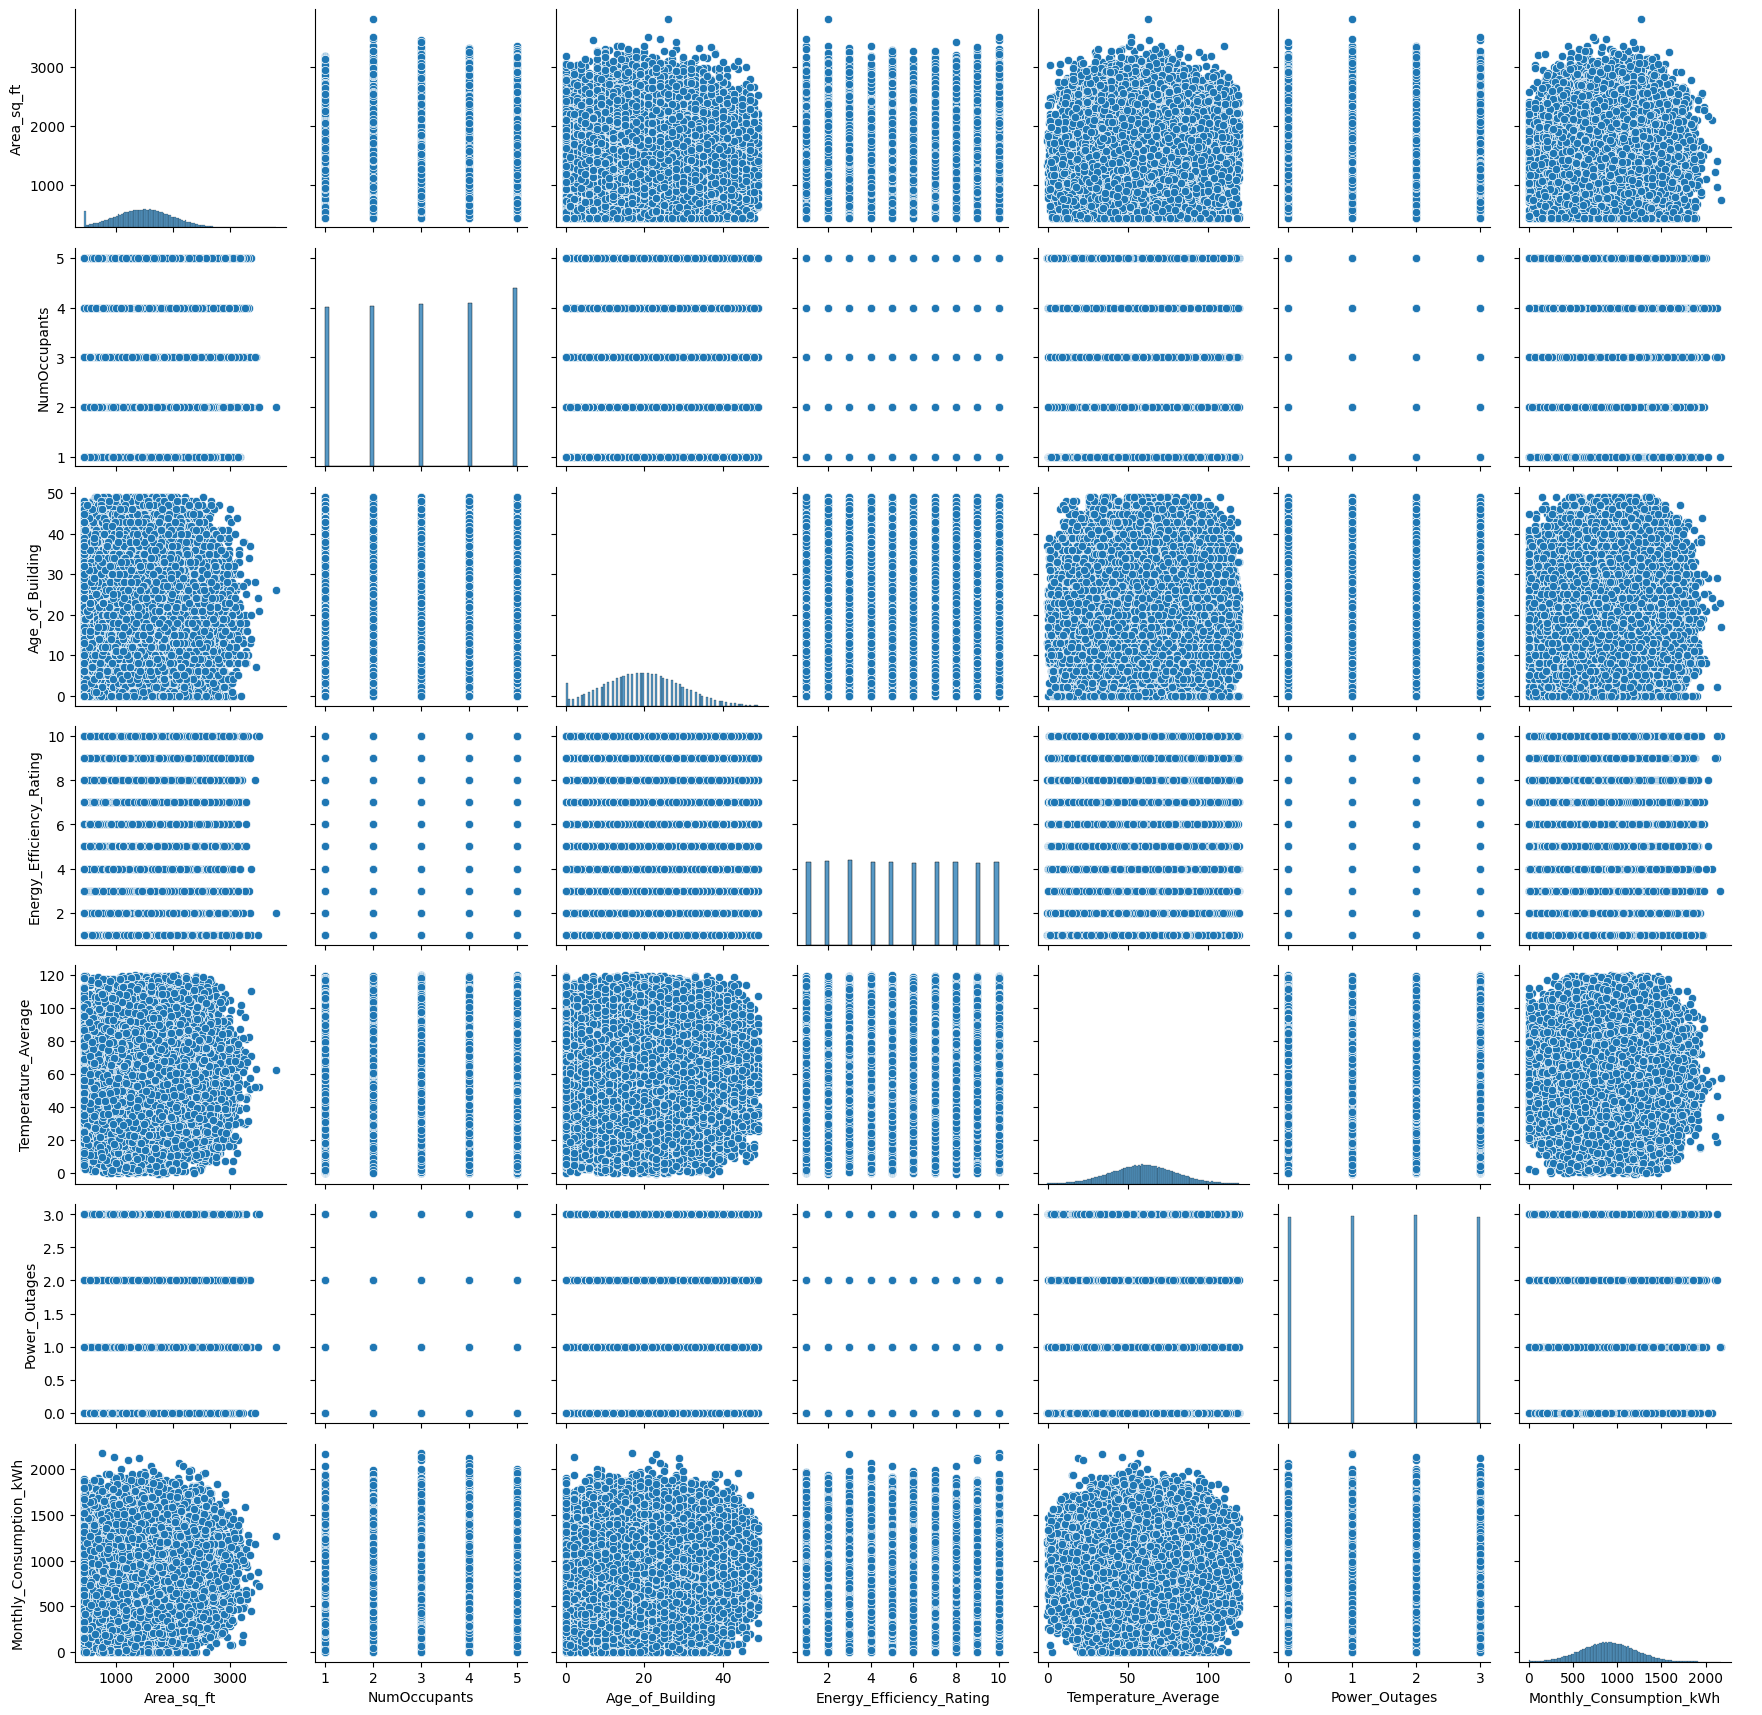

In [16]:
# Plotting of all attributes
g = sns.PairGrid(energy_consumption)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [17]:
# Check % of NA values in data set. This will help determine which imputer to use.
(energy_consumption.isnull().sum() / len(energy_consumption)) * 100

Area_sq_ft                     5.009
NumOccupants                   0.002
Type_of_heating               35.263
Age_of_Building                0.249
Insulation_Quality             0.000
Season                         0.000
Energy_Efficiency_Rating       0.000
Tariff_Type                    0.000
Renewable_Energy_Installed     0.000
Temperature_Average            5.267
Power_Outages                  0.000
Monthly_Consumption_kWh        0.000
dtype: float64

In [18]:
# Quick checking the number of unique values in each column
def check_unique_col(df):
    unique_values_dict = {}
    for col in df.columns:
        unique_values_dict[col] = df[col].unique().tolist()
    return unique_values_dict

unique_vals_col = check_unique_col(energy_consumption)

for i in unique_vals_col:
    print(len(unique_vals_col[i]))

2605
6
4
51
4
4
10
3
2
94734
4
99843


array([[<Axes: title={'center': 'Area_sq_ft'}>,
        <Axes: title={'center': 'NumOccupants'}>,
        <Axes: title={'center': 'Age_of_Building'}>],
       [<Axes: title={'center': 'Energy_Efficiency_Rating'}>,
        <Axes: title={'center': 'Temperature_Average'}>,
        <Axes: title={'center': 'Power_Outages'}>],
       [<Axes: title={'center': 'Monthly_Consumption_kWh'}>, <Axes: >,
        <Axes: >]], dtype=object)

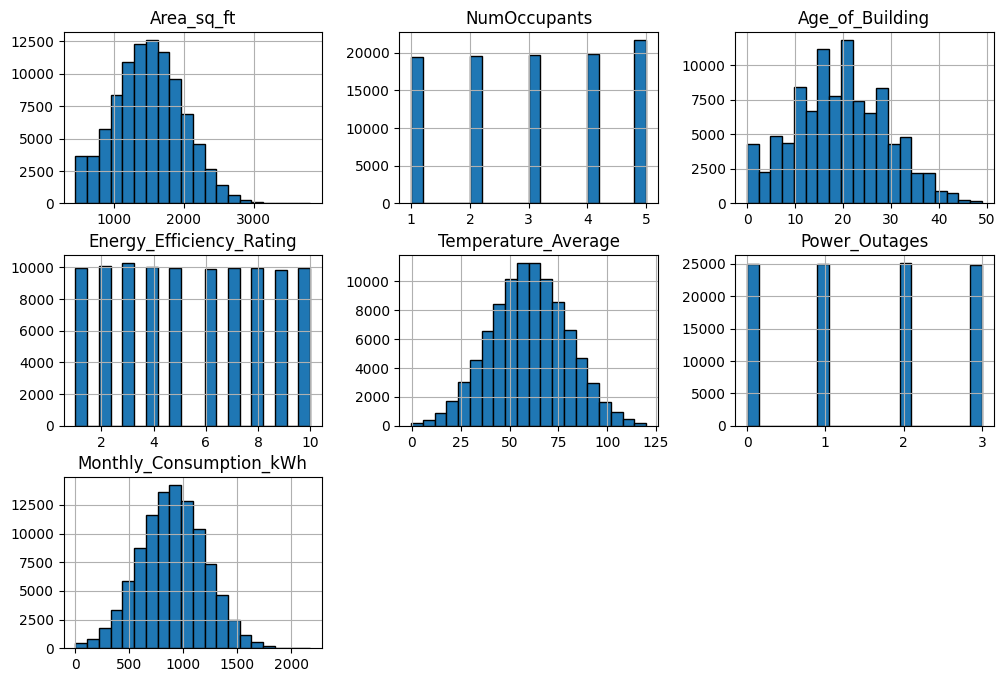

In [19]:
# Graphing to check for skewness.
# Used to determine what type of imputer to use.
import matplotlib.pyplot as plt
energy_consumption.hist(figsize=(12, 8), bins=20, edgecolor='black')

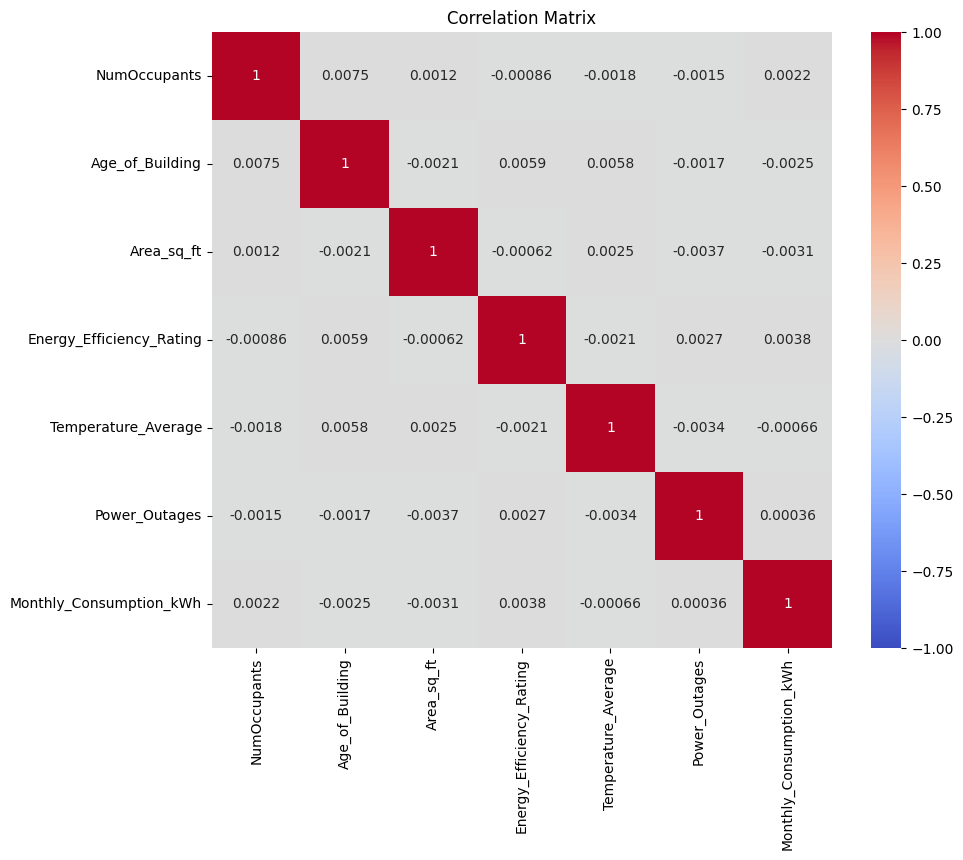

In [20]:
# Check correlation matrix
correlation_matrix = energy_consumption[['NumOccupants', 'Age_of_Building', 'Area_sq_ft', 'Energy_Efficiency_Rating',
                                         'Temperature_Average', 'Power_Outages', 'Monthly_Consumption_kWh']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_cols = ['NumOccupants', 'Age_of_Building', 'Area_sq_ft', 'Energy_Efficiency_Rating',
            'Temperature_Average', 'Power_Outages']
X_numeric = energy_consumption[vif_cols].fillna(energy_consumption[vif_cols].mean())
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_cols
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif_data)

                    Feature       VIF
0              NumOccupants  4.842733
1           Age_of_Building  4.490099
2                Area_sq_ft  7.762008
3  Energy_Efficiency_Rating  4.155759
4       Temperature_Average  7.686506
5             Power_Outages  2.652609


In [22]:
# Splitting data into training and validation sets
X = energy_consumption.drop(columns=['Monthly_Consumption_kWh'])
y = energy_consumption['Monthly_Consumption_kWh']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [24]:
# Contains imputer logic for filling all N/A entries with values
# Code for building our pipeline

# The below 3 functions are to create a ratio between 2 variables
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature name to be outputted


# Used to create the variable containing the following info---Age_Bin: Binning Age_of_Building
def age_bin(X):
    # X is a DataFrame with Age_of_Building
    # Binning of attributes to handle outliers better
    bins = [0, 10, 30, 70]
    labels = ['new', 'mid', 'old']
    age_values = X[:, 0].astype(float)
    age_binned = pd.cut(age_values, bins=bins, labels=labels, include_lowest=True)
    return np.array(age_binned).reshape(-1, 1)
    
def age_bin_name(function_transformer, feature_names_in):
    return ['Age_Bin']

# For data displaying a bell shape
bell_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# Uses simple imputer to fill in most frequent category if neccesary + onehotencoder for non-ordinal
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

cat_heating_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder(handle_unknown='ignore'),
)

# Used for ordinal categorical attributes
ord_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)

# Ratio pipeline for ratio between cols
ratio_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
)

# Pipeline for binning age
age_bin_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(age_bin, feature_names_out=age_bin_name),  # Fixed typo
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)

# Default pipeline for left over columns
default_num_pipeline = make_pipeline(
     SimpleImputer(strategy="median"),
     StandardScaler()
)

# Final preprocessing pipeline
preprocessing = ColumnTransformer([
    ("small_miss_cat", cat_pipeline, ["Season", "Tariff_Type", "Renewable_Energy_Installed"]),
    ("ord_encoder", ord_pipeline, ["Insulation_Quality"]),
    ("high_missing", cat_heating_pipeline, ["Type_of_heating"]),
    ("mean", bell_pipeline, ["Temperature_Average", "NumOccupants"]),
    ("occupant_per_area_sq", ratio_pipeline, ['NumOccupants', 'Area_sq_ft']),
    ("age_bin", age_bin_pipeline, ["Age_of_Building"]),
    ],
remainder=default_num_pipeline) 


In [25]:
# Filling in null values using an imputer
X_train = preprocessing.fit_transform(X_train)
print(X_train.shape)

(80000, 20)


In [26]:
X_test = preprocessing.fit_transform(X_test)
print(X_test.shape)

(20000, 20)


In [27]:
# Creating a LinerRegression model
lr = LinearRegression()
# Fitting the training data
lr.fit(X_train,y_train)

LinearRegression()

In [28]:
# Running the prediction on the data set
y_hat = lr.predict(X_test)

In [29]:
# Checking how well the model performed
rmse = root_mean_squared_error(y_test, y_hat)
print("Linear Regression RMSE:", rmse)
r2 = r2_score(y_test, y_hat)
print("Linear Regression r2:", r2)

Linear Regression RMSE: 302.32723695867116
Linear Regression r2: -0.0007709065863930054


In [30]:
# Using a different model, ridge regression
ridge = Ridge(random_state = 42, max_iter = 10000)

In [31]:
# Let's get the optimal value for the Alpha parameter
# clf means classifier. In this case we're using the ridge regression
alphas = np.logspace(-4,-0.5,30)
tuned_parameters = [{'alpha':alphas}]
n_folds = 5

clf = GridSearchCV(ridge,
                   tuned_parameters,
                   cv = n_folds,
                   scoring= "neg_mean_squared_error",
                   refit = True)

In [32]:
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

In [33]:
print("Ridge Coefficients:", clf.best_estimator_.coef_, '\n')
print("Ridge Intercept:", clf.best_estimator_.intercept_, '\n')
print("Ridge Best Estimator:", clf.best_estimator_, '\n')

Ridge Coefficients: [ -1.54899622  -5.05153961   6.26957704   0.33095879   1.09376243
  -3.34915811   2.25539568   2.03123734  -2.03123734  -0.78515332
   2.77515405   3.32586434 -10.10631686   4.00529847  -0.19814371
  -1.01736736   2.2984307    0.90090439   1.4886167   -0.21563839] 

Ridge Intercept: 896.6306462485564 

Ridge Best Estimator: Ridge(alpha=np.float64(0.31622776601683794), max_iter=10000, random_state=42) 



In [34]:
y_hat = clf.predict(X_test)

In [35]:
rmse = root_mean_squared_error(y_test, y_hat)
print("Ridge RMSE:", rmse)

r2 = r2_score(y_test, y_hat)
print("Ridge r2:", r2)

Ridge RMSE: 302.3272320450942
Ridge r2: -0.0007708740563112659


In [36]:
lasso = Lasso(random_state = 42, max_iter = 10000)

In [37]:
# Cross validation of alpha hyper parameter 
clf = GridSearchCV(lasso,
                   tuned_parameters,
                   cv = n_folds,
                   scoring = "neg_mean_squared_error",
                   refit = True)
                   

In [38]:
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
score_std = clf.cv_results_["std_test_score"]

In [39]:
print("Lasso Coefficients:", clf.best_estimator_.coef_, '\n')
print("Lasso Intercept:", clf.best_estimator_.intercept_, '\n')
print("Lasso Best Estimator:", clf.best_estimator_, '\n')

Lasso Coefficients: [-0.         -3.15076375  5.62322768  0.          0.         -3.49698755
  0.23561622  2.78865235 -0.         -0.53384398 -0.          0.
 -0.          0.         -0.         -0.          1.27832038  0.29075894
  1.17011316 -0.        ] 

Lasso Intercept: 898.8048628573582 

Lasso Best Estimator: Lasso(alpha=np.float64(0.31622776601683794), max_iter=10000, random_state=42) 



In [40]:
y_hat = clf.predict(X_test)

In [41]:
rmse = root_mean_squared_error(y_test, y_hat)
print("Lasso RMSE:", rmse)

r2 = r2_score(y_test, y_hat)
print("Lasso r2:", r2)

Lasso RMSE: 302.2796338307911
Lasso r2: -0.000455777355269138


In [42]:
parametersGrid  = {'nthread': [4],
                  'objective': ['reg:squarederror'],
                  'learning_rate':[0.01, 0.03, 0.05, 0.07, 0.1, 0.3],
                  'max_depth': [3, 5, 6, 7],
                  'min_child_weight': [4],
                  'verbosity': [1],
                  'subsample': [0.7, 0.9],
                  'colsample_bytree': [0.7],
                  'n_estimators':[100, 200, 300]}

model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb,
                   parametersGrid,
                   cv = n_folds,
                   scoring= "neg_mean_squared_error",
                   refit = True)


clf.fit(X_train, y_train)
model_xgb = clf.best_estimator_

y_hat = clf.predict(X_test)
rmse = root_mean_squared_error(y_test,y_hat)
print("XGBRegressor RMSE:", rmse)

r2 = r2_score(y_test, y_hat)
print("XGBRegressor r2:", r2)

XGBRegressor RMSE: 302.2813505626664
XGBRegressor r2: -0.0004671411324321806
